In [5]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, \
precision_recall_curve, auc
import os 
import sys

In [6]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

In [7]:
from fundamentas.stepbystep_v0 import StepByStep 

In [8]:
#data generation 
X , y = make_moons(n_samples= 100 , noise = 0.3 , random_state= 0)


In [9]:
#train test split
X_train , X_val , y_train , y_val = train_test_split(X , y ,test_size=0.2 , random_state= 13)
X_train.shape

(80, 2)

In [10]:
#standaerrize the feature using scikit learn standard scale 
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

In [11]:
import matplotlib.pyplot as plt 
import seaborn as sns 

In [12]:
X_train.shape

(80, 2)

## Data PreParation 

In [13]:
torch.manual_seed(42)
X_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train).view(-1,1).float()

X_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val).view(-1 , 1).float()

#make data set 
train_dataset = TensorDataset(X_train_tensor , y_train_tensor)
test_dataset = TensorDataset(X_val_tensor , y_val_tensor)

#build data loader 
train_loader = DataLoader(
    dataset= train_dataset , 
    shuffle= True , 
    batch_size= 16 )

val_loader = DataLoader(
    dataset= test_dataset , 
    batch_size = 16
)


There are two countries  , Country A  , Countrty B 
Country A has 75 percent of wining 
Country B has 100 - 75 -> 25% wining change

Wining odds are [probability]
3 to 1 (75 / 25)
and 1 to 3 (25 / 75) 

In [14]:
def ods_ratio(prob):
    return prob/(1-prob)

p = .75 
q = 1-p
ods_ratio(p) , ods_ratio(q) 
#note that these are the probabilities

(3.0, 0.3333333333333333)

# map probability in real number 

In [15]:
#by taking log of odds ratio , the funciton make its symemetrical and also maps probabilities into real numbers 
def log_odds_ratio(prob):
    return np.log(ods_ratio(prob))

p = .75
q = 1 - p 

log_odds_ratio(p) , log_odds_ratio(q)


(1.0986122886681098, -1.0986122886681098)

In [16]:
#sigmoid 
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
p = .75
q = 1-p
sigmoid(log_odds_ratio(p)) , sigmoid(log_odds_ratio(q))

(0.75, 0.25)

In [17]:
#sequential model to build own logistic regression in pytorch
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear' , nn.Linear(2 ,1))
model1.add_module('sigmoid' , nn.Sigmoid()) 
model1.state_dict()

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])),
             ('linear.bias', tensor([-0.1657]))])

## Loss 

#### let assume two dummy data points  
#### assume our model make prediction for them 0.9 and 0.2 
##### i.e 90 percent probability for being positive and 20% of being positive for actual negative 

In [18]:
dummy_lables = torch.tensor([1.0 , 0.0])
dummy_predictions = torch.tensor([0.9 , .2])

# positve class (lables = 1 )
positive_pred = dummy_predictions[dummy_lables== 1 ]
first_sumation = torch.log(positive_pred).sum()

negative_pred = dummy_predictions[dummy_lables == 0]
second_sumation = torch.log( 1 - negative_pred).sum()

# n total 
n_total = dummy_lables.size(0)
loss  = -(first_sumation + second_sumation) / n_total
loss 


tensor(0.1643)

first sum add's error corresponding to positive class ,
 second sums add's erros corresponing to negative class 

# BCELOSS

nn.BCELoss() is a higher function takes two argument 
1) reduction mean , sum, none 
2) weight , default is none 

In [19]:
loss_fn = nn.BCELoss(reduce= 'mean')
loss_fn

d:\software\miniconda\envs\mlenv\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


BCELoss()

## important  , always pass prediction first and then laels  , the order matters 

In [141]:
rightway_loss = loss_fn(dummy_predictions , dummy_lables)
wrongway_loss = loss_fn(dummy_lables , dummy_predictions)
rightway_loss , wrongway_loss 

(tensor(0.1643), tensor(15.0000))

#### Another Binary Cross Entropy
### BCEWITHLOGITS 
### nn.BECWITHLogitsLoss()

nn.BCELoss() loss function took probabilities as an argument but this function takes logits as an argument , 
meaning you should not add sigmoid as last layer and the 

In [142]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction = 'mean')
loss_fn_logits

BCEWithLogitsLoss()

In [143]:
# we need to give logits 
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)
dummy_logits = torch.tensor([logit1 , logit2])

dummy_logits , dummy_lables

(tensor([ 2.1972, -1.3863], dtype=torch.float64), tensor([1., 0.]))

In [144]:
# comptue loss

loss_fn_logits(dummy_logits , dummy_lables)

tensor(0.1643)

### we got the same result 

# testing with imblance data set  [pos_weight argument ]

### there are three times more data points in
### the negative class than in the positive one👇🏽

In [145]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

In [146]:
no_of_points_in_negative_class = (dummy_imb_labels == 0).sum().float()
no_of_points_in_positive_class  = (dummy_imb_labels ==1).sum().float()

############  points in negative  / positive class ########### 
no_of_points_in_negative_class  , no_of_points_in_positive_class

(tensor(3.), tensor(1.))

In [147]:
pos_weight = no_of_points_in_negative_class / no_of_points_in_positive_class

In [148]:
# create another function 
loss_fn_imbalance = nn.BCEWithLogitsLoss(reduction= 'mean' , 
                                         pos_weight = pos_weight )

In [149]:
#now calcuate loss using this weighted loss fucntion 
loss = loss_fn_imbalance(dummy_imb_logits , dummy_imb_labels)
print(loss , '❌❌' , 'our loss should be 0.1643 not this  ' )

tensor(0.2464) ❌❌ our loss should be 0.1643 not this  


In [150]:
## pytorch does't compute the weigited average  , 
### so to tackle this , we will use sum insted of mean and give our own denomitor 

In [152]:
pos_weight

tensor(3.)

In [159]:
loss_fn_imbalance_sum = nn.BCEWithLogitsLoss(reduction= 'sum', 
                                             pos_weight= pos_weight)

loss = loss_fn_imbalance(dummy_imb_logits , dummy_imb_labels)
loss = loss / (pos_weight * no_of_points_in_negative_class * no_of_points_in_positive_class )
print(loss , '⁉️⁉️⁉️⁉️🤔🤔')

tensor(0.0274) ⁉️⁉️⁉️⁉️🤔🤔


In [162]:
## model configuration
model = nn.Sequential()
torch.manual_seed(42)
model.add_module('linear' , nn.Linear(2, 1))
lr = 0.01

optimizer = optim.SGD(model.parameters() , lr = lr )
losss_fn = nn.BCEWithLogitsLoss()

In [164]:
#model tranning 
n_epochs= 100 
sbs = StepByStep(model , loss_fn , optimizer )
sbs.train(n_epochs)

❌❌❌❌ bug ? 


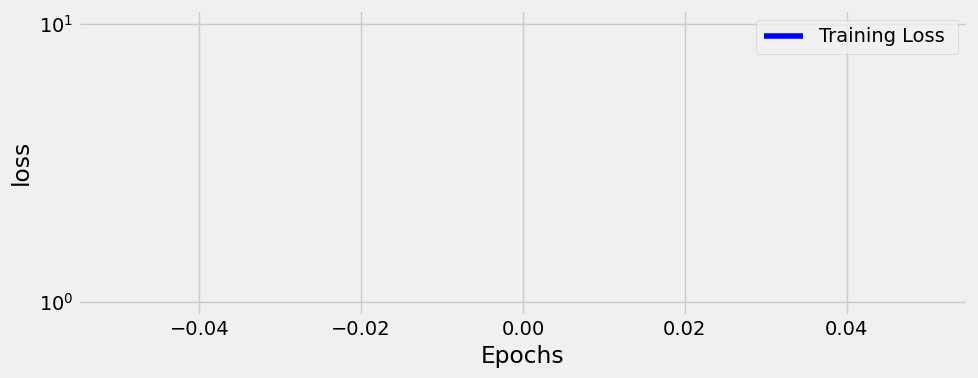

In [166]:
fig = sbs.plot_losses()
print('❌❌❌❌ bug ? ')

In [167]:
#check model trained or notm
model.state_dict()

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]], device='cuda:0')),
             ('linear.bias', tensor([-0.1657], device='cuda:0'))])